## Problem: Detection of aggressive tweets

Training dataset has 16000 tweets (in english) which are labeled (by human) as:
* 1 (Cyber-Aggressive; 9714 items)
* 0 (Non Cyber-Aggressive; 6286 items)

### Dividing data into the training and test part

In [151]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [152]:
data = pd.read_json('./Data/train.json')
data.head()

,content,label
0,my weak camera I hate it. I want one of the Hi...,0
1,tell me you didnt ask him if he was gay haha,0
2,I hate you.,1
3,What movie do you know every line to?,0
4,yea :D,0


In [153]:
np.unique(data.label, return_counts=True)

(array([0, 1], dtype=int64), array([9714, 6286], dtype=int64))

In [154]:
X = data.content
y = data.label

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [147]:
print('Training data: ', 'class 1 contribution = %.2f' % y_train.mean(), 
      '# = %s' % X_train.shape[0], sep='\n', end='\n\n')
print('Test data: ', 'class 1 contribution = %.2f' % y_test.mean(), 
      '# = %s' % X_test.shape[0], sep='\n')

Training data: 
class 1 contribution = 0.39
# = 12800

Test data: 
class 1 contribution = 0.39
# = 3200


### Preprocessing

In [6]:
from sklearn.base import TransformerMixin
import nltk
import string

In [178]:
# check if the field 'content' is always filled
data.content.isnull().sum()

0

In [186]:
# check if the field 'content' is always filled
(data.content == '').sum()

0

In [166]:
class BasicPreprocessor(TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        PUNCTUATION = string.punctuation
        STOPWORDS = nltk.corpus.stopwords.words('english')
        stemmer = nltk.PorterStemmer()
        
        X_lower = [doc.lower() for doc in X]
        X_tokenized = [nltk.word_tokenize(doc) for doc in X_lower]
        X_cleaned = [[token for token in doc_tokenized 
                      if token not in PUNCTUATION and token not in STOPWORDS]
                    for doc_tokenized in X_tokenized]
        X_stemmed = [[stemmer.stem(token) for token in doc_tokenized]
                     for doc_tokenized in X_cleaned]
        X_preprocessed = [' '.join(doc_tokenized) for doc_tokenized in X_stemmed]
        return X_preprocessed

### Baseline model

In [194]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [168]:
pipe = Pipeline([('preprocessor', BasicPreprocessor()),
                 ('vectorizer', CountVectorizer()),
                 ('clf', LogisticRegression(penalty='l2', C=1.0))])

In [172]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', <__main__.BasicPreprocessor object at 0x0000022DB98FFA90>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [173]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

Accuracy seems to be a good metric because:
* distribution of classes is quite symmetric (1 - 39%, 0 - 61%),
* false positive (FP) and false negative (FN) have similar cost - we don't want to have too many FP and FN.

In [252]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [174]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.907
Test dataset: accuracy = 0.801


In [316]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred) / len(y_true)
    
    fig, ax = plt.subplots(figsize=(3, 3))    
    ax.matshow(conf_mat, cmap=plt.cm.Greens, alpha=0.5)
    
    labels = np.unique(y_true)
    for i, j in itertools.product(labels, repeat=len(labels)):
        ax.annotate(s='%.2f' % conf_mat[i, j], xy=(j, i), va='center', ha='center')
        
    ax.set_xlabel('Predicted label', size=14)
    ax.set_ylabel('Real label', size=14)
    plt.show()

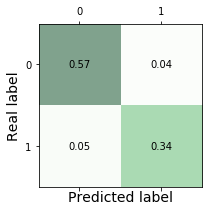

In [317]:
plot_confusion_matrix(y_train, y_train_pred)

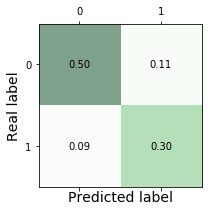

In [318]:
plot_confusion_matrix(y_test, y_test_pred)

There is similar rate of FP and FN so it seems that the threshold of 0.5 is correct.<br/>
We can check it using ROC as well.

In [390]:
from sklearn.metrics import roc_curve

In [325]:
y_test_proba = pipe.predict_proba(X_test)[:, 1]

In [327]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_test_proba)

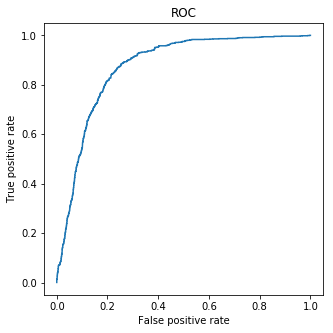

In [330]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fprs, tprs)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC')
plt.show()

In [411]:
ind = np.argmax(tprs >= 0.8)

print('FPR: %.3f' % fprs[ind])
print('TPR: %.3f' % tprs[ind])
threshold = thresholds[ind]
print('Threshold: %.3f' % threshold)

FPR: 0.191
TPR: 0.802
Threshold: 0.486


In [412]:
y_test_pred_new_threshold = np.where(y_test_proba >= threshold, 1, 0)

In [413]:
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred_new_threshold, y_true=y_test))

Test dataset: accuracy = 0.806


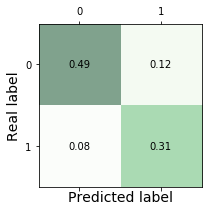

In [414]:
plot_confusion_matrix(y_test, y_test_pred_new_threshold)